# `StableSpectralElements.jl` - 1D Euler equations with entropy-stable Gauss collocation methods

Let's first load StableSpectralElements.jl and a few other packages that we will need for this example.

In [47]:
using StableSpectralElements, OrdinaryDiffEq
using TimerOutputs, Plots, Printf, StaticArrays

We're going to solve the one-dimensional Euler equations on the space-time domain $(x,t) \in (0,L) \times (0,T)$, as given by
$$
\begin{aligned}
\partial_t \rho(x,t) + \partial_x (\rho(x,t)V(x,t)) &= 0\\
\partial_t (\rho(x,t)V(x,t)) + \partial_x(\rho(x,t)V(x,t)^2 + P(x,t)) &= 0,\\
\partial_t E(x,t) + \partial_x((E(x,t) + P(x,t))V(x,t)) &= 0, 
\end{aligned}
$$
where $\rho(x,t)$, $V(x,t)$, and $E(x,t)$ are the density, velocity, and total energy per unit volume, respectively, and the pressure is given by
$$
P(x,t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(x,t) V(x,t)^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. We prescribe periodic boundary conditions on a domain of length $L = 2$ and an initial condition of $V(x,0) = P(x,0) = 1$, and
$$
\rho(x,0) = 1 + 0.2\sin(\pi x),
$$
which results in an exact solution given by a propagating density wave at unit velocity. We will solve for a single period, i.e., until $T = 2$.

In [48]:
T = 2.0
L = 2.0
conservation_law = EulerEquations{1}(1.4)

function exact_sol(x,t)
    γ = 1.4
    ρ = 1.0 + 0.2sin(π*x)
    v = 1.0
    E = 1.0/(γ-1) + 0.5*ρ
    return SVector{3}(ρ, ρ*v, E)
end

exact_sol (generic function with 1 method)

Now we'll discretize in space using an [entropy-conservative Gauss collocation method](https://arxiv.org/abs/1809.01178) of degree $p = 5$ on a mesh of $M = 4$ elements. This requires a flux differencing formulation, wherein the entropy variables are used to extrapolate the solution to the endpoints of each element, and a facet correction is applied, an approach equivalent to the use of [hybridized summation-by-parts operators](https://arxiv.org/abs/1708.01243).

In [49]:
p = 5
M = 4

reference_approximation = ReferenceApproximation(
    NodalTensor(p), Line(), volume_quadrature_rule=LGQuadrature(p))
    
mesh = uniform_periodic_mesh(reference_approximation, (0.0, L), M)

spatial_discretization = SpatialDiscretization(mesh, reference_approximation)

form = FluxDifferencingForm(inviscid_numerical_flux=EntropyConservativeNumericalFlux())

ode = semidiscretize(conservation_law, spatial_discretization, exact_sol, 
    form, (0.0, T), ReferenceOperator())

results_path = save_project(conservation_law, spatial_discretization, exact_sol, form, 
    (0.0, T), "results/euler_1d/", overwrite=true, clear=true)

dt=T/1000;

We can now run the simulation as usual using OrdinaryDiffEq.jl.

In [50]:
reset_timer!()
sol = solve(ode, CarpenterKennedy2N54(), dt=dt, adaptive=false, 
        save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.68s /  24.2%            265MiB /  25.9%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual    5.05k    406ms  100.0%  80.4μs   68.5MiB  100.0%  13.9KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each conservative variable can then be computed with respect to the travelling density wave solution.

In [51]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_sol, T))

L2 error:
[3.580856017198903e-5, 5.212982861193392e-5, 0.00012637647533692264]


Using the snapshot data, the scheme is seen to conserve all three primary quantities (mass, momentum, and energy), as well as entropy.

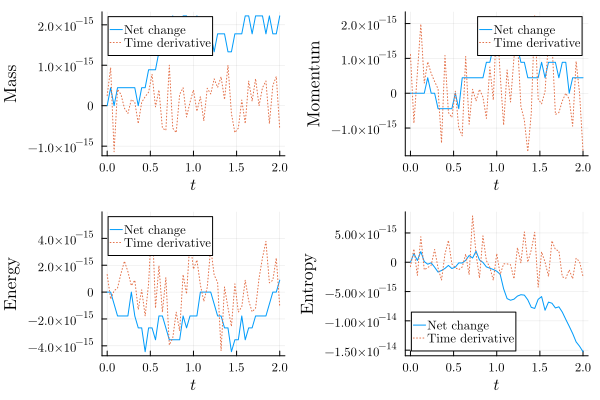

In [52]:
time_steps = load_time_steps(results_path)
conservation_results = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization), time_steps)
entropy_results = analyze(EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization), time_steps)

mass = plot(conservation_results, ylabel="Mass", 1)
momentum = plot(conservation_results, ylabel="Momentum", 2)
energy = plot(conservation_results, ylabel="Energy", 3)
entropy = plot(entropy_results, ylabel="Entropy")


plot(mass, momentum, energy, entropy, size=(600,400), fmt=:png)

Finally, we'll create an animation of the density wave.

[ Info: Saved animation to /Users/tristanmontoya/Research/StableSpectralElements.jl/examples/figures/euler_1d_solution.gif


Plots.AnimatedGif("/Users/tristanmontoya/Research/StableSpectralElements.jl/examples/figures/euler_1d_solution.gif")
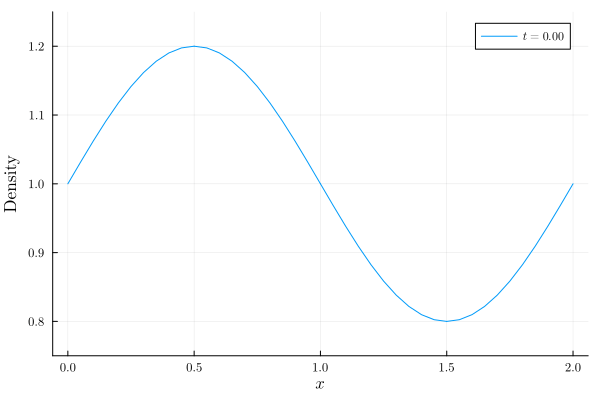

In [53]:
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i],
        ylims=[0.75,1.25], ylabel="Density", fontfamily="Computer Modern",
        label=string("\$t = \$", @sprintf "\$%.2f\$" sol.t[i]),
        legend=:topright)
end
gif(anim, "figures/euler_1d_solution.gif", fps = 10)